In this post, I propose and implement a method of quality ranking scotches that attempts to remove as much as possible the preferences and tasting ability of raters from influencing the ultimate ranking results. First, I define the ranking method, then I implement it, generating a list of the "best" scotches.

#### Method

To rank scotches, one first needs to specify a set of criteria by which to judge every scotch. Once those criteria are defined, the "best" scotches will be those that rank most highly according to the criteria. I propose complexity and balance as the essential criteria to judge scotch. (These criteria are based upon Brooks in Whisky and Philosophy.) 

Imagine the ideal or perfect scotch. According to one theory, that scotch would possess all the possible flavors that a scotch could possess. For example, it would be fruity, smoky, peaty, et cetera. A scotch that possesses a large number of the possible flavors that a scotch could posses is called complex or multidimensional. In additional, in the ideal scotch each of the flavors would be distinct, not muddled, and discernible. No small group of flavors would dominate all of the others. If a scotch possesses this quality, it is called balanced. So not only does the ideal scotch possess a large number of flavors, it possess them in right proportion to one another so that all are identifiable. 

The complex and balanced a scotch is, the more closely it approximates the ideal scotch and the higher it ranks according to this method.

#### Implementation

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
file_name = 'whiskies_w_coords.csv'
top_scotches_to_map = 5

In [3]:
data = pd.read_csv(file_name)
to_rename = {
    'whiskies.Latitude':'FinalLat',
    'whiskies.Longitude':'FinalLong'
}
data = data.rename(columns=to_rename)
data = data.set_index('Distillery')
data = data.loc[:,'Body':]

In [34]:
flavors = data.loc[:, 'Body':'Floral']
location = data.loc[:, 'FinalLat':]

How can one actually implement this method of ranking scotches? Before I answer that question, I will describe the data are used as inputs to the method. The data, which can be sourced from this site [source], describe the range and intensity of flavors that are present in a given scotch. The data set has 12 columns; each one corresponding to a different flavor that may be present in scotch, for example sweetness, smoky, honey, or floral. Each row of the data set corresponds to a distillery, and each distillery is only represented by a single record. Each distillery is rated from 0 to 4 in each flavor category; 0 being low/no intensity to 5 being high intensity. You may ask, how is each distillery able to be represented by single record? The reason is that each distillery is rated based upon its most popular issuance. The 0 to 4 ratings were assigned initially by a small panel of experts, then passed around to various other members of the whisky industry for feedback. See [source] for more info on the data and the details of the original analysis, including clustering and principal component analysis, done with this data

In [35]:
flavors.head()

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
Distillery,,,,,,,,,,,,
Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2
Aberlour,3,3,1,0,0,4,3,2,2,3,3,2
AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2
Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0
Ardmore,2,2,2,0,0,1,1,1,2,3,1,1


Batches vary. barrels vary. single malts are subject to variation. taste is not objective due to preference and tasting ability. though the ideal sctoch can be defined objectively? at least what "best" or "ideal" means

so now that we have determined the best or ideal scotches that doesn't mean you will like them. that's preference based. and tasting ability.

what are the properties of the rating system? mean? count? std?

assuming intensity of flavor is a positive, but variance of intensity is not.

use experts to describe characteristics of whisky but not determine rank. we are interested in a rating/ranking scheme, not a classification one.

have characteristics concerning smell and taste, missing others? like visual ones?

enjoying/preferring a scotch is not the same as it being the best/ideal

this rating scheme has a big negative. it doesn't require any tasting on my part.

#### Calculate individual scores and ranking

two characteristics: 1) complex (count), 2) balance (mean/std). how to combine these two to get an unique ranking?

what are the characteristics that I want in my rating system?
-captures balance and complexity of final product, not a measure of preference.

talk about the data set

what does "best" mean? "best" means "as close as possible to the ideal." So define what "ideal" is and judge the quality of a product by how close it approximated the ideal. Ideal = complex/multidimensional and balance. complex means has as many as of the possible flavors contained in the ideal scotch as possible. balance means that those flavors are all discernible and not dominated by a small subset of those flavors.

1. capture complexity by counting the number of characteristics with non-zero intensity rating
2. capture balance by calculating the mean flavor intensity divided by standard deviation of flavor intensities. using mean the idea is that a more intense flavor is better than a less intense one. using standard deviation, the idea being that a scotch with similar ratings across flavor categories is more balanced than one with more disparate flavor intensities. so "idealness" decreases as the standard deviation of flavor intensities increases. call this the "score."

then all scotches with available tasting notes are ranking scotches in descending order first by non-zero flavor count, then by score. the scotches at the top of the list are the "best" scotches in the sense of being closes to the "ideal."

this ranking does allow a scotch with a lower score but more non-zero flavors to be ranked higher than one a higher score but fewer non-zeros. is that a problem? better way to rank according to the two criterion?

In [6]:
flavors_count = flavors != 0
ratings = pd.DataFrame()
ratings['NonZeroFlavors'] = flavors_count.sum(axis=1)

next calculate average rating per whisky and standard deviation of scores. higher mean is better. lower standard deviation is better since whisky is more balanced and no characteristic dominates its flavor profile.

In [7]:
ratings['Mean'] = flavors.mean(axis=1)
ratings['Std'] = flavors.std(axis=1)
ratings['Score'] = ratings['Mean']/ratings['Std']

In [8]:
ratings.head()

,NonZeroFlavors,Mean,Std,Score
Distillery,,,,
Aberfeldy,10,1.583333,0.792961,1.996734
Aberlour,10,2.166667,1.267304,1.709665
AnCnoc,8,1.416667,1.164500,1.216545
Ardbeg,8,1.583333,1.621354,0.976550
Ardmore,10,1.333333,0.887625,1.502135


In [16]:
by_count_score = ratings.sort_values(by=['NonZeroFlavors', 'Score'], ascending=False).reset_index()
by_score_count = ratings.sort_values(by=['Score', 'NonZeroFlavors'], ascending=False).reset_index()
by_mean = ratings.sort_values(by='Mean', ascending=False).reset_index()
by_std = ratings.sort_values(by='Std', ascending=False).reset_index()

show by_mean, by_score, then by_score_count?

In [17]:
by_count_score.head(10)

,Distillery,NonZeroFlavors,Mean,Std,Score
0,Bruichladdich,11,1.583333,0.668558,2.368281
1,OldPulteney,11,1.500000,0.674200,2.224860
2,Scapa,11,1.500000,0.674200,2.224860
3,Bowmore,11,1.500000,0.797724,1.880350
4,OldFettercairn,11,1.500000,0.797724,1.880350
5,Dalmore,11,1.666667,0.887625,1.877669
6,RoyalBrackla,11,1.666667,0.887625,1.877669
7,Craigallechie,11,1.750000,0.965307,1.812894
8,Highland Park,11,1.416667,0.792961,1.786552
9,Bunnahabhain,11,1.333333,0.778499,1.712698


not surprised the extreme scotches are ranked top by std since severaly dominated by a few flavor characteristics 

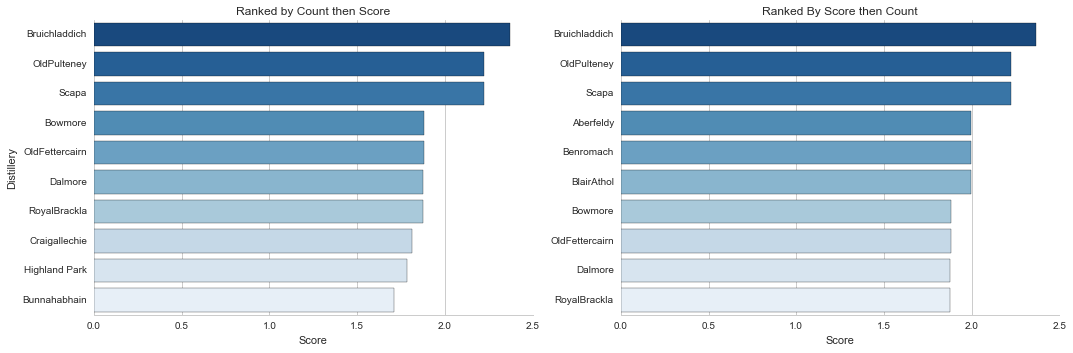

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x='Score', y='Distillery', data=by_count_score[:10],palette="Blues_r", ax=ax1)
ax1.set(title='Ranked by Count then Score', xlabel="Score", xlim=(0,2.5))

sns.barplot(x='Score', y='Distillery', data=by_score_count[:10],palette="Blues_r", ax=ax2)
ax2.set(ylabel='', title='Ranked By Score then Count', xlabel="Score", xlim=(0,2.5))

# Finalize the plot
sns.despine(bottom=False, left=True)
plt.tight_layout(h_pad=3)

top ranked scotches mapped. are the top scotches confined to a specific geographic region?

In [19]:
map_data = by_count_score.head(top_scotches_to_map).merge(location, how='left', left_index=True, right_index=True)

In [20]:
map_data.reset_index().loc[:,['FinalLat','FinalLong','Distillery']].to_csv('top_whiskies.csv')

if ranking is not indicative of highest quality scotches, why might that be? essential component of flavor or something else missing? flavor classification is not? advertisment, quality is responsible for notierity of certain brands. our definition of "best" differs from how most judge whisky. for example, the smoky islay scotches won't be at the top of the list due to their extreme flavor profile, though interestingly the top ranked scotch is from islay, just not one of the smoky guys. notice this rating system is all about balance.

now that we have a rating. we can potentially calculate the best value by taking into account price as well. divide by price?

can also use this method for evaluating a variety of "goods", like a husband or wife, an apartment, etcetc


reference 
1. brooks
2. http://whiskyanalysis.com/index.php/methodology-introduction/methodology-flavour-comparison/
3. https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html- 